In [2]:
import umap
import numpy as np
import numpy.linalg as la
import requests
import os
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import math
#Fashion mnist
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn import linear_model, ensemble, tree, neighbors, svm
from mnist.loader import MNIST
%notebook

UsageError: the following arguments are required: filename


In [3]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

Fetching Fashion-Mnist
Fashion-Mnist loaded


## Completion bar

In [3]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [4]:
def rotate(theta,image):
    
    theta=math.radians(theta)                               #converting degrees to radians
    cosine=math.cos(theta)
    sine=math.sin(theta)
                                 
    
    # Compute augmented image dimensions
    new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
    new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

    #init temp matrix to be populated with individually rotated elements
    output=np.zeros((new_height,new_width))
    # Identify point of rotation in original image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
    original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image
    
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width 

            #Applying shear Transformation                     
            new_y,new_x=shear(theta,x,y)
            #Adjust coordinates to be relative to the new center after rotation
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            output[new_y,new_x]=image[i,j]                          #writing the pixels to the new destination in the output image
    """
    #trim output: 
    # iterate through matrix, if there exists an element less than tau round it down to 0
    tau=.1
    for j in range(output.shape[0]):
        for k in range(output.shape[0]):
            if output[j][k]<tau:
                output[j][k]=np.rint(output[j][k])
    # identify indices of zero rows and columns and delete them from the final matrix( could be done with less lines )
    idx = np.argwhere(np.all(output[..., :] == 0, axis=0))
    o2 = np.delete(output, idx, axis=0)
    idy = np.argwhere(np.all(output[..., :] == 0, axis=1))
    o3= np.delete(o2, idy, axis=1)
    return o3           
    """
    return output

In [5]:
# A shear is used here to avoid issues with anti aliasing, method described by 
#vhttps://www.ocf.berkeley.edu/~fricke/projects/israel/paeth/rotation_by_shearing.html
def shear(angle,x,y):
    '''
    |1  -tan(𝜃/2) |  |1        0|  |1  -tan(𝜃/2) | 
    |0      1     |  |sin(𝜃)   1|  |0      1     |
    '''
    
    tangent=math.tan(angle/2)
    new_x=round(x-y*tangent)
    new_y=y
    
    new_y=round(new_x*math.sin(angle)+new_y)      #since there is no change in new_x according to the shear matrix
    new_x=round(new_x-new_y*tangent)              #since there is no change in new_y according to the shear matrix
    
    return new_y,new_x

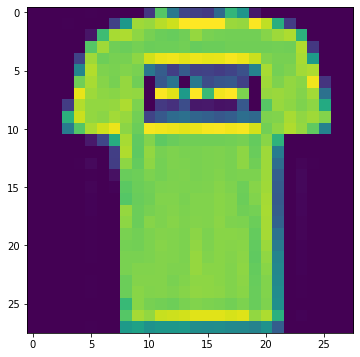

(41, 41)


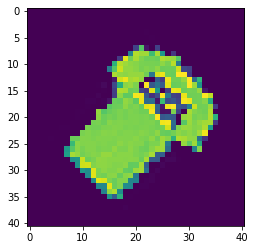

In [6]:
#testing rotations on sample image 


l=np.reshape(data[1],(28,28))
fig = plt.figure( figsize=(8, 6))
plt.imshow(l, cmap='viridis')
plt.show()

#fails for 5,6 degrees for some reason, debugging needed 
i=rotate(45,l)
print(i.shape)

plt.imshow(i, cmap='viridis')
plt.show()

## Experiment Design 

The following experiment is aimed at investigating different methodologies of correcting rotated images back to their canonical state. This investigation is being conducted in order to determine the worst case solution for improving umaps ability to handle rotational augmentations in the data. A high time complexity is expected most likely a quadratic addition as we will be preforming an additional evaluation for each step. Modifications will be done locally at first to test proficiency of the algorithm that scaled to a custom version of the umap embedding function where we can see how the sourrounding class structure handles modifications to the data. Today 9/20's develeopment process is cenetered around the goal of the local problem of identifying 1-3 different ways of correcting for rotational augmentations

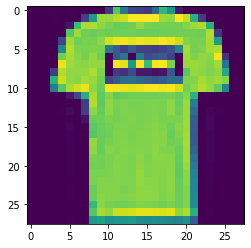

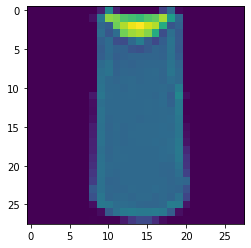

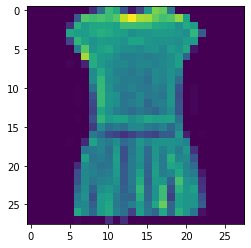

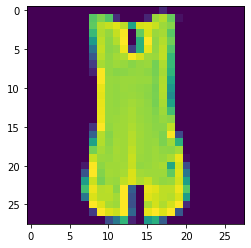

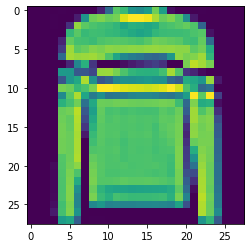

In [54]:
#define control samples for each clothing type 
shirt_control=np.reshape(data[1],(28,28))
plt.imshow(shirt_control, cmap='viridis')
plt.show()
dress_control=np.reshape(data[2],(28,28))
plt.imshow(dress_control, cmap='viridis')
plt.show()
dress_control=np.reshape(data[3],(28,28))
plt.imshow(dress_control, cmap='viridis')
plt.show()
dress_control=np.reshape(data[4],(28,28))
plt.imshow(dress_control, cmap='viridis')
plt.show()
dress_control=np.reshape(data[5],(28,28))
plt.imshow(dress_control, cmap='viridis')
plt.show()
